In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/heart_disease_cleaned_new.csv')

Mounted at /content/drive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   cp        920 non-null    int64  
 3   trestbps  920 non-null    int64  
 4   chol      920 non-null    int64  
 5   fbs       920 non-null    int64  
 6   restecg   920 non-null    int64  
 7   thalch    920 non-null    int64  
 8   exang     920 non-null    int64  
 9   oldpeak   920 non-null    float64
 10  slope     920 non-null    int64  
 11  ca        920 non-null    int64  
 12  thal      920 non-null    int64  
 13  target    920 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 100.8 KB


In [6]:
x = df.drop('target', axis=1)
y = df['target']

In [7]:
# Normalize the input features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [8]:
# Convert tabular rows to image
def tabular_to_image(x_row, img_size=224):
    side = int(np.ceil(np.sqrt(x_row.shape[0])))
    padded = np.pad(x_row, (0, side*side - x_row.shape[0]), mode='constant')
    image = padded.reshape(side, side)
    image = np.stack([image]*3, axis=-1)
    image_resized = resize(image, (img_size, img_size), mode='reflect', anti_aliasing=True)
    return image_resized

x_images = np.array([tabular_to_image(x) for x in x_scaled])


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_images, y, test_size=0.2, random_state=42)


In [10]:
#Build EfficientNet Model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.5234 - loss: 0.6979 - val_accuracy: 0.4932 - val_loss: 0.6943
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5292 - loss: 0.7010 - val_accuracy: 0.5068 - val_loss: 0.7021
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.5575 - loss: 0.6901 - val_accuracy: 0.5068 - val_loss: 0.6954
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.5564 - loss: 0.6888 - val_accuracy: 0.5068 - val_loss: 0.6936
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5324 - loss: 0.6984 - val_accuracy: 0.5068 - val_loss: 0.7116
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.5428 - loss: 0.6972 - val_accuracy: 0.5068 - val_loss: 0.6927
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5517 - loss: 0.6977 - val_accuracy: 0.5068 - val_loss: 0.6977
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5347 - loss: 0.7021 - val_accuracy: 0.5068 - val_loss:

In [12]:
# 🧪 Evaluate
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("Test Accuracy:", accuracy_score(y_test, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
Test Accuracy: 0.592391304347826


In [13]:
# Extract values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


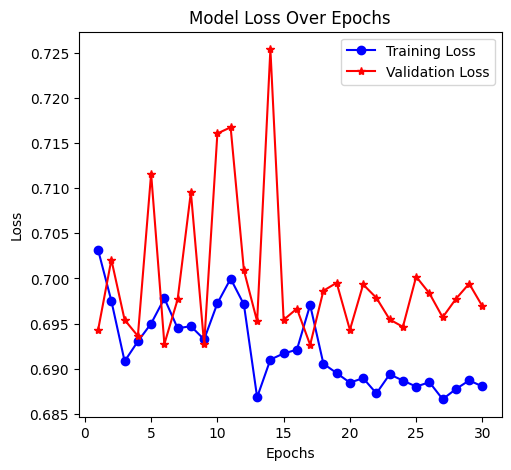

In [14]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

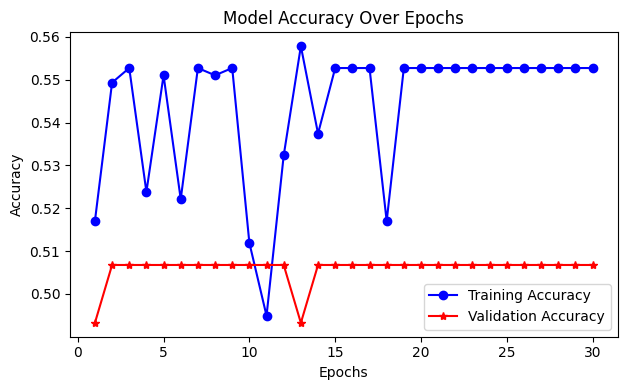

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results
evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


{'total_parameters': 4131620,
 'FLOPs': 800949208,
 'GFLOPs': 0.800949208,
 'model_size_bytes': 17916160,
 'model_size_MB': 17.086181640625,
 'inference_time_seconds': 20.917365789413452,
 'accuracy': 0.592391312122345}